# Load squares.csv

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np

squares_path = "/content/drive/My Drive/ChessDiagramRecognition/squares.csv"
data = np.genfromtxt(squares_path, delimiter=",")

print(data.shape)

(6400, 1025)


In [ ]:
ids_map = {
  "black_square": {
    "empty": 0,
    "black_pawn": 1,
    "black_rook": 2,
    "black_knight": 3,
    "black_bishop": 4,
    "black_queen": 5,
    "black_king": 6,
    "white_pawn": 7,
    "white_rook": 8,
    "white_knight": 9,
    "white_bishop": 10,
    "white_queen": 11,
    "white_king": 12
  },
  "white_square": {
    "empty": 13,
    "black_pawn": 14,
    "black_rook": 15,
    "black_knight": 16,
    "black_bishop": 17,
    "black_queen": 18,
    "black_king": 19,
    "white_pawn": 20,
    "white_rook": 21,
    "white_knight": 22,
    "white_bishop": 23,
    "white_queen": 24,
    "white_king": 25
  }
}

def get_id_to_square_dict() -> dict:
    result = {}
    squares_ids = ids_map
    for square_color, pieces in squares_ids.items():
        for piece, piece_id in pieces.items():
            result[piece_id] = square_color + "_" + piece

    return result

ids_dict = get_id_to_square_dict()

In [ ]:
# Plot random examples

import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

def plot_random_examples(param_data, plot_h=5, plot_w=5):
  figure = plt.figure(figsize=(plot_h,plot_w))

  for i in range(plot_h * plot_w):
    sub = figure.add_subplot(plot_h, plot_w, i + 1)
    random_id = np.random.randint(param_data.shape[0])
    image = param_data[random_id, 1:].reshape(32, 32)
    sub.imshow(image, cmap="gray")
    plt.axis("off")

def plot_random_example_with_label(param_data):
  id = np.random.randint(param_data.shape[0])
  print(ids_dict[param_data[id, 0]])
  imgplot = plt.imshow(param_data[id, 1:].reshape(32, 32), cmap="gray")
  return id

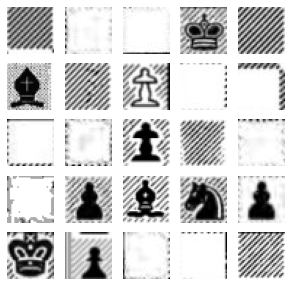

In [ ]:
plot_random_examples(data)

white_square_empty


5025

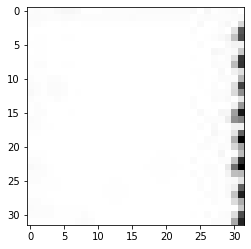

In [ ]:
plot_random_example_with_label(data)

In [ ]:
print("Dataset distribution per class:")
for i in range(26):
  print("id={}{}".format(ids_dict[i].ljust(30), data[data[:, 0] == i].shape[0]))

Dataset distribution per class:
id=black_square_empty            2046
id=black_square_black_pawn       281
id=black_square_black_rook       78
id=black_square_black_knight     56
id=black_square_black_bishop     60
id=black_square_black_queen      47
id=black_square_black_king       45
id=black_square_white_pawn       300
id=black_square_white_rook       73
id=black_square_white_knight     60
id=black_square_white_bishop     57
id=black_square_white_queen      42
id=black_square_white_king       55
id=white_square_empty            2010
id=white_square_black_pawn       295
id=white_square_black_rook       86
id=white_square_black_knight     55
id=white_square_black_bishop     59
id=white_square_black_queen      52
id=white_square_black_king       55
id=white_square_white_pawn       292
id=white_square_white_rook       92
id=white_square_white_knight     53
id=white_square_white_bishop     56
id=white_square_white_queen      50
id=white_square_white_king       45


# Split data to train_data and test_data

In [ ]:
np.random.shuffle(data)

szt = 10 # size of test data per category, rest is for train data

test_data = np.zeros(shape=(26*szt, 1025), dtype=np.uint8)
original_train_data = np.zeros(shape=(0, 1025), dtype=np.uint8)

for i in range(26):
  test_data[szt*i:szt*(i+1), :] = data[data[:, 0]==i, :][0:szt, :]
  original_train_data = np.vstack((original_train_data,data[data[:, 0]==i, :][szt:, :]))

In [ ]:
np.random.shuffle(test_data)
np.random.shuffle(original_train_data)

In [ ]:
print(original_train_data.shape)
print(test_data.shape)

(6140, 1025)
(260, 1025)


# Data Augmentation

In [ ]:
number_of_examples = {}
print("Train distribution per class:")
for i in range(26):
  number_of_examples[i] = original_train_data[original_train_data[:, 0] == i].shape[0]
  print("id={}\t{}".format(ids_dict[i].ljust(30), original_train_data[original_train_data[:, 0] == i].shape[0]))

Train distribution per class:
id=black_square_empty            	2036
id=black_square_black_pawn       	271
id=black_square_black_rook       	68
id=black_square_black_knight     	46
id=black_square_black_bishop     	50
id=black_square_black_queen      	37
id=black_square_black_king       	35
id=black_square_white_pawn       	290
id=black_square_white_rook       	63
id=black_square_white_knight     	50
id=black_square_white_bishop     	47
id=black_square_white_queen      	32
id=black_square_white_king       	45
id=white_square_empty            	2000
id=white_square_black_pawn       	285
id=white_square_black_rook       	76
id=white_square_black_knight     	45
id=white_square_black_bishop     	49
id=white_square_black_queen      	42
id=white_square_black_king       	45
id=white_square_white_pawn       	282
id=white_square_white_rook       	82
id=white_square_white_knight     	43
id=white_square_white_bishop     	46
id=white_square_white_queen      	40
id=white_square_white_king       	35


In [ ]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
  rotation_range=2,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.02,
  zoom_range=0.05,
  fill_mode="nearest"
)

In [ ]:
sz = 300 # new size per category

new_train_data = np.zeros(shape=(26 * sz, 1025), dtype=np.uint8)

for i in range(26):
  square_data = np.zeros(shape=(sz, 1025), dtype=np.uint8)
  square_data[:, 0] = i
  if sz <= number_of_examples[i]:
    square_data[0: sz, :] = original_train_data[original_train_data[:, 0] == i][0:sz]
  else:
    square_data[0: number_of_examples[i], :] = original_train_data[original_train_data[:, 0] == i]

    new_example = number_of_examples[i]
    random_example = np.random.randint(number_of_examples[i])

    for batch in datagen.flow(square_data[random_example, 1:].reshape(1, 32, 32, 1), batch_size=1):
      square_data[new_example, 1:1025] = batch[0].reshape((1, 1024))
      new_example += 1
      if new_example == sz:
        break
      random_example = np.random.randint(number_of_examples[i])

  new_train_data[sz*i : (sz*(i+1)), :] = square_data


################################################################################
print("New train distribution per class:")
for i in range(26):
  print("id={}\t{}".format(ids_dict[i].ljust(30), new_train_data[new_train_data[:, 0] == i].shape[0]))

New train distribution per class:
id=black_square_empty            	300
id=black_square_black_pawn       	300
id=black_square_black_rook       	300
id=black_square_black_knight     	300
id=black_square_black_bishop     	300
id=black_square_black_queen      	300
id=black_square_black_king       	300
id=black_square_white_pawn       	300
id=black_square_white_rook       	300
id=black_square_white_knight     	300
id=black_square_white_bishop     	300
id=black_square_white_queen      	300
id=black_square_white_king       	300
id=white_square_empty            	300
id=white_square_black_pawn       	300
id=white_square_black_rook       	300
id=white_square_black_knight     	300
id=white_square_black_bishop     	300
id=white_square_black_queen      	300
id=white_square_black_king       	300
id=white_square_white_pawn       	300
id=white_square_white_rook       	300
id=white_square_white_knight     	300
id=white_square_white_bishop     	300
id=white_square_white_queen      	300
id=white_square_

In [ ]:
np.random.shuffle(new_train_data)
train_data = new_train_data

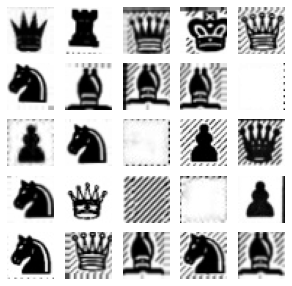

In [ ]:
plot_random_examples(train_data)

black_square_white_bishop


1663

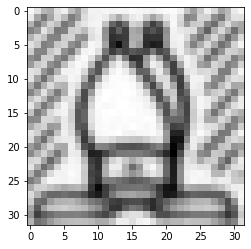

In [ ]:
plot_random_example_with_label(train_data)

# Train model

In [ ]:
# Split train_data to train_data_black and train_data_white

train_data_black = np.zeros(shape=(13*sz, 1025), dtype=np.uint8)
train_data_white =  np.zeros(shape=(13*sz, 1025), dtype=np.uint8)

for i in range(13):
  train_data_black[sz*i:sz*(i+1), :] = train_data[train_data[:,0]==i, :][0:sz, :]

for i in range(13):
  train_data_white[sz*i:sz*(i+1), :] = train_data[train_data[:,0]==i+13, :][0:sz, :]

train_data_white[:, 0] -= 13

print(train_data_black.shape)

print(train_data_white.shape)

(3900, 1025)
(3900, 1025)


black_square_black_bishop


1351

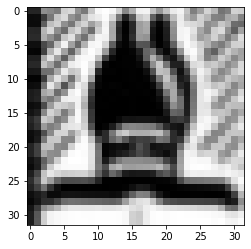

In [ ]:
plot_random_example_with_label(train_data_black)

In [ ]:
# Split test_data to test_data_black and test_data_white

test_data_black = test_data[test_data[:, 0] <= 12]
test_data_white = test_data[test_data[:, 0] >= 13]
test_data_white[:, 0] -= 13

print(test_data_black.shape)
print(test_data_white.shape)

(130, 1025)
(130, 1025)


black_square_white_rook


107

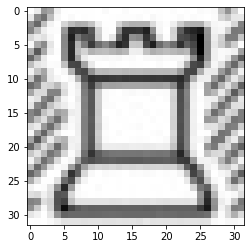

In [ ]:
plot_random_example_with_label(test_data_black)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

num_classes = 13
input_shape = (32, 32, 1)

black_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

black_model.summary()

white_model = models.clone_model(black_model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0

In [ ]:
train_images_black = train_data_black[:, 1:]
train_images_white = train_data_white[:, 1:]
train_labels_black = train_data_black[:, 0]
train_labels_white = train_data_white[:, 0]

In [ ]:
test_images_black = test_data_black[:, 1:]
test_images_white = test_data_white[:, 1:]
test_labels_black = test_data_black[:, 0]
test_labels_white = test_data_white[:, 0]

In [ ]:
train_images_black = train_images_black.reshape(-1, 32, 32) # Only for CovNet
train_images_white = train_images_white.reshape(-1, 32, 32) # Only for CovNet
test_images_black = test_images_black.reshape(-1, 32, 32) # Only for CovNet
test_images_white = test_images_white.reshape(-1, 32, 32) # Only for CovNet
train_images_black = train_images_black.astype("float32") / 255.0
train_images_white = train_images_white.astype("float32") / 255.0
test_images_black = test_images_black.astype("float32") / 255.0
test_images_white = test_images_white.astype("float32") / 255.0
train_images_black = np.expand_dims(train_images_black, -1) # Only for CovNet
train_images_white = np.expand_dims(train_images_white, -1) # Only for CovNet
test_images_black = np.expand_dims(test_images_black, -1) # Only for CovNet
test_images_white = np.expand_dims(test_images_white, -1) # Only for CovNet
print(train_images_black.shape)

(3900, 32, 32, 1)


In [ ]:
from keras.utils import to_categorical

train_labels_black = to_categorical(train_labels_black, num_classes)
train_labels_white = to_categorical(train_labels_white, num_classes)
test_labels_black = to_categorical(test_labels_black, num_classes)
test_labels_white = to_categorical(test_labels_white, num_classes)

Using TensorFlow backend.


In [ ]:
batch_size = 128
epochs = 20

black_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
white_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

black_model.fit(train_images_black, train_labels_black, batch_size=batch_size, epochs=epochs)
white_model.fit(train_images_white, train_labels_white, batch_size=batch_size, epochs=epochs)

Epoch 1/20
31/31 [==============================] - 0s 16ms/step - loss: 1.9108 - accuracy: 0.3533
Epoch 2/20
31/31 [==============================] - 0s 10ms/step - loss: 0.6030 - accuracy: 0.8185
Epoch 3/20
31/31 [==============================] - 0s 10ms/step - loss: 0.1952 - accuracy: 0.9469
Epoch 4/20
31/31 [==============================] - 0s 11ms/step - loss: 0.1134 - accuracy: 0.9700
Epoch 5/20
31/31 [==============================] - 0s 10ms/step - loss: 0.0707 - accuracy: 0.9808
Epoch 6/20
31/31 [==============================] - 0s 10ms/step - loss: 0.0593 - accuracy: 0.9854
Epoch 7/20
31/31 [==============================] - 0s 11ms/step - loss: 0.0429 - accuracy: 0.9895
Epoch 8/20
31/31 [==============================] - 0s 10ms/step - loss: 0.0390 - accuracy: 0.9897
Epoch 9/20
31/31 [==============================] - 0s 10ms/step - loss: 0.0350 - accuracy: 0.9913
Epoch 10/20
31/31 [==============================] - 0s 11ms/step - loss: 0.0282 - accuracy: 0.9933
Epoch 11/

In [ ]:
train_loss_black, train_acc_black = black_model.evaluate(train_images_black, train_labels_black, verbose=0)
train_loss_white, train_acc_white = white_model.evaluate(train_images_white, train_labels_white, verbose=0)

In [ ]:
print("Black:\n\ttest_acc:", train_acc_black)
print("White:\n\ttest_acc:", train_acc_white)

Black:
	test_acc: 0.9997435808181763
White:
	test_acc: 0.9997435808181763


In [ ]:
test_loss_black, test_acc_black = black_model.evaluate(test_images_black, test_labels_black, verbose=0)
test_loss_white, test_acc_white = white_model.evaluate(test_images_white, test_labels_white, verbose=0)

In [ ]:
print("Black:\n\ttest_acc:", test_acc_black)
print("White:\n\ttest_acc:", test_acc_white)

Black:
	test_acc: 0.9923076629638672
White:
	test_acc: 0.9769230484962463


(130, 32, 32, 1)
black_square_white_queen
Predicted label: black_square_white_queen


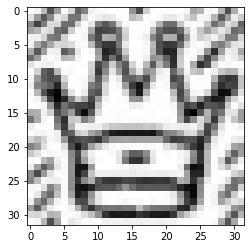

In [ ]:
print(test_images_black.shape)
y_prob = black_model.predict(test_images_black)
y_classes = y_prob.argmax(axis=-1)
id = plot_random_example_with_label(np.hstack((y_classes.reshape(-1, 1), test_images_black.reshape(-1, 1024))))
print("Predicted label:", ids_dict[y_classes[id]])

In [ ]:
black_model.save("black_model.h5")
white_model.save("white_model.h5")